<a href="https://colab.research.google.com/github/celso-vitor/StomataCount/blob/main/StomataCount.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Step 1: Install required libraries
!pip install opencv-python numpy matplotlib

# Step 2: Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Step 3: Upload one or more images
print("Please upload one or more images:")
uploaded = files.upload()



Please upload one or more images:


Saving CAN PEQNA N4.bmp to CAN PEQNA N4.bmp



Processing image: CAN PEQNA N4.bmp


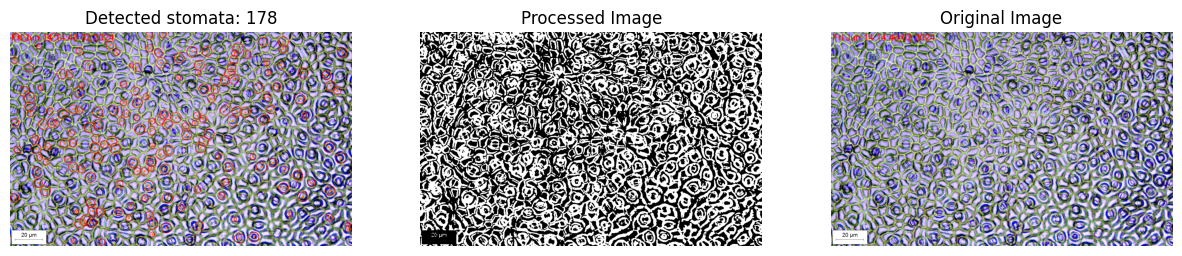


Final Summary:
Image: CAN PEQNA N4.bmp | Detected stomata: 178


In [11]:
# List to store the results for each image
results = []

# Loop over all uploaded images
for image_name, image_data in uploaded.items():
    print(f"\nProcessing image: {image_name}")

    # Step 4: Convert to grayscale
    img_gray = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)

    # Step 5: Pre-processing
    def preprocess_image(img_gray):
        # Enhance contrast (CLAHE)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_clahe = clahe.apply(img_gray)

        # Noise reduction (median filter)
        img_blur = cv2.medianBlur(img_clahe, 3)

        # Binarization (Otsu's threshold)
        _, img_bin = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Morphological operations to refine image
        kernel = np.ones((3, 3), np.uint8)
        img_dilated = cv2.dilate(img_bin, kernel, iterations=1)
        img_eroded = cv2.erode(img_dilated, kernel, iterations=1)
        img_final = cv2.morphologyEx(img_eroded, cv2.MORPH_OPEN, kernel, iterations=1)

        return img_final

    img_processed = preprocess_image(img_gray)

    # Step 6: Detect circles using Hough Transform
    def detect_circles(img_processed):
        img_processed = np.uint8(img_processed)
        circles = cv2.HoughCircles(
            img_processed,
            method=cv2.HOUGH_GRADIENT,
            dp=1.2,
            minDist=10,
            param1=80,
            param2=28,
            minRadius=5,
            maxRadius=30
        )
        if circles is not None:
            return np.round(circles[0, :]).astype("int")
        else:
            return []

    circles = detect_circles(img_processed)

    # Step 7: Filter overlapping circles
    def filter_overlapping_circles(circles):
        if len(circles) == 0:
            return circles

        filtered_circles = []
        used_indices = set()

        for i in range(len(circles)):
            if i in used_indices:
                continue

            x1, y1, r1 = circles[i]
            keep_circle = True

            for j in range(i + 1, len(circles)):
                if j in used_indices:
                    continue

                x2, y2, r2 = circles[j]
                distance = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

                if distance < (r1 + r2) * 0.6:
                    if r1 > r2:
                        used_indices.add(j)
                    else:
                        used_indices.add(i)
                        keep_circle = False
                        break

            if keep_circle:
                filtered_circles.append(circles[i])

        return np.array(filtered_circles)

    circles = filter_overlapping_circles(circles)

    # Step 8: Draw circles on the original image
    def draw_circles(image_path, circles):
        img_color = cv2.imread(image_path)
        for (x, y, r) in circles:
            cv2.circle(img_color, (x, y), r, (0, 0, 255), 2)
            cv2.rectangle(img_color, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
        return img_color

    img_with_circles = draw_circles(image_name, circles)

    # Step 9: Display results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img_with_circles, cv2.COLOR_BGR2RGB))
    plt.title(f"Detected stomata: {len(circles)}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(img_processed, cmap='gray')
    plt.title("Processed Image")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    plt.show()

    # Save the result for this image
    results.append({
        "image_name": image_name,
        "stomata_count": len(circles)
    })

# Final summary
print("\nFinal Summary:")
for result in results:
    print(f"Image: {result['image_name']} | Detected stomata: {result['stomata_count']}")
